# TOC

0. [Imports](#first-bullet)
1. [EDA](#1.0-bullet)
2. [New Features](#2.0-bullet)  
 2.1 [Datetime](#2.1-bullet)  
 2.2 [Description](#2.2-bullet)  
 2.3 [Tags](#2.3-bullet)  
 2.4 [Title](#2.4-bullet)  
 2.5 [Ratios](#2.5-bullet)  
3. [Output & Dictionary - Part 1](#3.0-bullet)  
4. [Part 2: Unsupervised Engagement](#4.0-bullet)

# <a class="anchor" id="0.0-bullet"> 0. Imports & Basic Measures</a>

In [1]:
#Basic
import pandas as pd
import numpy as np
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
#import requests
#import json

#Youtube Data API Packages: 
"""from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
from googleapiclient.discovery import build
import argparse
from googleapiclient.errors import HttpError"""

#Modeling
# from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
# #from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# #from sklearn.cluster import KMeans
# #from sklearn.svm import SVC
# from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

#NLP & Text Management
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.stem import PorterStemmer

#Time analysis
import time
import datetime
"""from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf"""

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

In [1]:
df_main = pd.read_csv('./data/clean_data_nocomments_noviews_02.10.18.csv')

#create log features
df_main['view_log'] = df_main['viewCount'].map(lambda x: 0 if x==0 else np.log10(x)) #Which log to use???
df_main['comment_log'] = df_main['commentCount'].map(lambda x: 0 if x==0 else np.log10(x))
df_main['like_log'] = df_main['likeCount'].map(lambda x: 0 if x==0 else np.log10(x))
df_main['dislike_log'] = df_main['dislikeCount'].map(lambda x: 0 if x==0 else np.log10(x))
df_main['view_class'] = df_main.view_log.astype(int)

df_main.publishedAt = pd.to_datetime(df_main.publishedAt)

df_main.description.fillna('', inplace=True)
df_main.tags.fillna('', inplace=True)

#Running all the vectorizers is memory instensive. Don't do it by accident.
Run_Text_Analysis = False

NameError: name 'pd' is not defined

# <a class="anchor" id="1.0-bullet"> 2. Adding Features</a>

## <a class="anchor" id="1.0-bullet"> 2.1 Datetime</a>
 * Week Number
 * is Weekend
 * Year

In [ ]:
df_main['week'] = df_main.publishedAt.map(lambda x: x.week)

In [75]:
df_main['is_weekend'] = df_main.publishedAt.dt.weekday.map(lambda x: 1 if x == 5 or x==6 else 0)

In [76]:
df_main['is_friday'] = df_main.publishedAt.dt.weekday.map(lambda x: 1 if x == 4 else 0)

In [71]:
# df_main['year'] exists

## <a class="anchor" id="2.2-bullet"> 2.2 Description Analysis</a>
 * Sentiment description_sentiment
 * Overall word count description_wordcount
 * CVEC matrix

In [3]:
#Score description words with Textblob
df_main['description_sentiment'] = df_main['description'].map(lambda x: TextBlob(str(x)).sentiment.polarity) 

In [4]:
#Count Spaces
df_main['description_wordcount'] = df_main['description'].map(lambda x: str(x).count(' '))

In [5]:
if Run_Text_Analysis: 
    corp = ''
    #Remove links to other websites in initial vector fit, along with carriage returns
    for i in range(df_main.shape[0]):
        corp += re.sub(r'http[^ ]+', '',df_main.iloc[i]['description']).replace("\r", '').replace("\n", '')
    #single row dataframe to allow for quick integration with count vectorizer
    df_corp= pd.DataFrame([corp], index=[1])
    cvec = CountVectorizer()
    df_cvec_description = cvec.fit_transform(df_corp[0]).todense()
    df_cvec_description = pd.DataFrame(df_cvec_description, columns = cvec.get_feature_names())
    
    #Only retaining words that appear often enough for a basic model to catch them. 
    #Otherwise, this vector is about 10 GB
    descr_words = [col for col in df_cvec_description.columns if df_cvec_description[col].sum()>200]

    lmtzr = PorterStemmer()
    lem_list = []
    for word in descr_words:
        lem_list.append(lmtzr.stem(word))
    #remove duplicates
    lem_list = list(set(lem_list))
    #Keep video Id as index
    df_descr_word_vec = df_main.loc[:, ['description', 'vidId']]
    
    for i in range(df_descr_word_vec.shape[0]):
        df_descr_word_vec.at[i,'description'] = ' '.join([lmtzr.stem(word) for word in (re.sub(r'http[^ ]+', '', \
                                                                                               df_descr_word_vec.description[i]).replace("\r", '').replace("\n", '')).split(' ')])
    #Create columns so that words can be identified
    for word in lem_list:
        df_descr_word_vec[str('descr_word_' + word)] = df_descr_word_vec.description.str.count(word)

    df_descr_word_vec.to_csv('./data/engineered_data/description_wordvec.csv')

## <a class="anchor" id="2.3-bullet"> 2.3 Tags</a>
 * Sentiment
 * CVEC
 * Num tags

In [6]:
df_main['tags_sentiment'] = df_main['tags'].map(lambda x: TextBlob(str(x)).sentiment.polarity)
#count number of tags based on commas, rather than total words
df_main['tags_wordcount'] = df_main['tags'].map(lambda x: str(x).count(','))

In [7]:
if Run_Text_Analysis: 
    corp = ''
    for i in range(df_main.shape[0]):
        try:
            corp += re.sub(r'http[^ ]+', '',df_main.iloc[i]['tags']).replace("\r", '').replace("\n", '')
        except:
            next

    df_corp= pd.DataFrame([corp], index=[1])
    cvec = CountVectorizer()
    df_cvec_tags = cvec.fit_transform(df_corp[0]).todense()
    df_cvec_tags = pd.DataFrame(df_cvec_tags, columns = cvec.get_feature_names())

    tags_words = [col for col in df_cvec_tags.columns if df_cvec_tags[col].sum()>200]

    lmtzr = PorterStemmer()
    lem_list = []
    for word in tags_words:
        lem_list.append(lmtzr.stem(word))
    lem_list = list(set(lem_list))
    df_tags_word_vec = df_main.loc[:, ['tags', 'vidId']]

    for i in range(df_tags_word_vec.shape[0]):
        try:
            df_tags_word_vec.at[i,'tags'] = ' '.join([lmtzr.stem(word) for word in (re.sub(r'http[^ ]+', '', \
                                                                                           df_tags_word_vec.tags[i]).replace("\r", '').replace("\n", '')).split(' ')])
        except:
            df_tags_word_vec.at[i,'tags'] = ''

    for word in lem_list:
        df_tags_word_vec[str('tags_word_' + word)] = df_tags_word_vec.tags.str.count(word)

    df_tags_word_vec.fillna(0, inplace=True)

    df_tags_word_vec.to_csv('./data/engineered_data/tag_wordvec.csv')

## <a class="anchor" id="2.4-bullet"> 2.4 Title Analysis</a>
 * Sentiment
 * Wordcount
 * CVEC predictions
 * feat / ft. 
 * Which letters
 * Length

In [8]:
df_main['title_sentiment'] = df_main['title'].map(lambda x: TextBlob(str(x)).sentiment.polarity)
df_main['title_wordcount'] = df_main['title'].map(lambda x: str(x).count(' '))

In [9]:
feat_words = ['feat', 'ft', 'featur']
def find_feats(text_string):
    text_string = text_string.lower()
    for word in feat_words:
        if word in text_string:
            return 1
    return 0
df_main['title_featuring'] = df_main['title'].map(lambda x: find_feats(x))

In [10]:
df_main[df_main['title_featuring']==1]['viewCount'].mean() / df_main[df_main['title_featuring']==0]['viewCount'].mean()

2.7215569134095174

In [11]:
letters = 'abcdefghijklmnopqrstuvwxyz'
for letter in letters:
    df_main[str('intitle_' + letter)] = df_main.title.str.count(letter)

In [12]:
df_main.intitle_e.corr(df_main.viewCount)

-0.0008536683101137517

In [13]:
dict_letters = {}
for letter in letters:
     dict_letters[letter] = df_main['intitle_'+letter].corr(df_main.viewCount)

sorted_by_value = sorted(dict_letters.items(), key=lambda kv: kv[1])

sorted_by_value

[('p', -0.03946633529244498),
 ('b', -0.03627860822539604),
 ('s', -0.03514826615159203),
 ('r', -0.027404929357270034),
 ('m', -0.027279484193756025),
 ('v', -0.026577086391472934),
 ('g', -0.02449266351460775),
 ('z', -0.02239357878936587),
 ('x', -0.021399371434054345),
 ('j', -0.02137359415623475),
 ('o', -0.02070718509871761),
 ('w', -0.014108489879490082),
 ('n', -0.01217125240695847),
 ('q', -0.007299119232882848),
 ('c', -0.006712985589303544),
 ('t', -0.002084847977073171),
 ('u', -0.0010196579409205704),
 ('e', -0.0008536683101137517),
 ('y', 0.0009580579318070765),
 ('l', 0.004137700055334141),
 ('h', 0.006063303890828201),
 ('d', 0.020119382926463092),
 ('a', 0.027141420170195565),
 ('k', 0.030337263703497507),
 ('i', 0.04360353842855648),
 ('f', 0.13541303454369089)]

Look at f go!

In [14]:
df_main['title_length'] = df_main['title'].map(lambda x: len(str(x)))

In [15]:
df_main.title_length.corr(df_main.view_log)

0.02566059747225844

In [16]:
if Run_Text_Analysis: 
    corp = ''
    for i in range(df_main.shape[0]):
        try:
            corp += re.sub(r'http[^ ]+', '',df_main.iloc[i]['title']).replace("\r", '').replace("\n", '')
        except:
            next

    df_corp= pd.DataFrame([corp], index=[1])
    cvec = CountVectorizer()
    df_cvec_title = cvec.fit_transform(df_corp[0]).todense()
    df_cvec_title = pd.DataFrame(df_cvec_title, columns = cvec.get_feature_names())

    title_words = [col for col in df_cvec_title.columns if df_cvec_title[col].sum()>200]

    lmtzr = PorterStemmer()
    lem_list = []
    for word in title_words:
        lem_list.append(lmtzr.stem(word))
    lem_list = list(set(lem_list))
    df_title_word_vec = df_main.loc[:, ['title', 'vidId']]

    for i in range(df_title_word_vec.shape[0]):
        try:
            df_title_word_vec.at[i,'title'] = ' '.join([lmtzr.stem(word) for word in (re.sub(r'http[^ ]+', '', \
                                                                                           df_title_word_vec.title[i]).replace("\r", '').replace("\n", '')).split(' ')])
        except:
            df_title_word_vec.at[i,'title'] = ''

    for word in lem_list:
        df_title_word_vec[str('title_word_' + word)] = df_title_word_vec.title.str.count(word)

    df_title_word_vec.fillna(0, inplace=True)

    df_title_word_vec.to_csv('./data/title_wordvec.csv')

## <a class="anchor" id="2.5-bullet"> 2.5 Ratios</a>

#### Likes / Views

In [17]:
df_main[(df_main['likeCount']>0)&(df_main['viewCount']<=5)]['likeCount']

5632      1
5845    527
6235      1
6236      1
8498     82
Name: likeCount, dtype: int64

In [18]:
#Messing up the ratios with likecounts on videos with no views
df_main.at[5632, 'likeCount'] = 0
df_main.at[5845, 'likeCount'] = 0
df_main.at[6235, 'likeCount'] = 0
df_main.at[6236, 'likeCount'] = 0
df_main.at[6279, 'likeCount'] = 0
df_main.at[8498, 'likeCount'] = 0

In [26]:
df_main['lv_ratio'] = (df_main['like_log'] / df_main['view_log'])

df_main['lv_ratio'].fillna(1, inplace=True)

df_main.loc[: , ['lv_ratio', 'viewCount', 'view_log']].corr()

,lv_ratio,viewCount,view_log
lv_ratio,1.000000,0.176668,0.691731
viewCount,0.176668,1.000000,0.376019
view_log,0.691731,0.376019,1.000000


#### comments / views

In [36]:
df_main[(df_main['commentCount']>0)&(df_main['viewCount']<=0)]['commentCount']

5845    67
8498     3
Name: commentCount, dtype: int64

In [37]:
df_main.at[5845, 'commentCount'] = 0
df_main.at[8498, 'commentCount'] = 0

In [24]:
df_main['comment_view_ratio'] = (df_main['comment_log'] / df_main['view_log'])

df_main['comment_view_ratio'].fillna(1, inplace=True)

df_main.loc[: , ['comment_view_ratio', 'viewCount', 'view_log']].corr()

,comment_view_ratio,viewCount,view_log
comment_view_ratio,1.000000,0.236108,0.753268
viewCount,0.236108,1.000000,0.376019
view_log,0.753268,0.376019,1.000000


In [ ]:
#Skip dislike / view: same as comment

#### Dislikes / Likes

In [38]:
df_main[(df_main['dislikeCount']>0)&(df_main['viewCount']<=0)]['dislikeCount']

5845    27
8498    10
Name: dislikeCount, dtype: int64

In [39]:
df_main.at[5845, 'dislikeCount'] = 0
df_main.at[8498, 'dislikeCount'] = 0

In [27]:
df_main['like_dislike_ratio'] = (df_main['like_log'] / df_main['dislike_log'])

df_main['like_dislike_ratio'].fillna(1, inplace=True)

df_main.loc[: , ['like_dislike_ratio', 'viewCount', 'view_log']].corr()

,like_dislike_ratio,viewCount,view_log
like_dislike_ratio,1.000000,-0.140453,-0.538152
viewCount,-0.140453,1.000000,0.376019
view_log,-0.538152,0.376019,1.000000


#### Deal with infinities

In [57]:
df_main['lv_ratio'].value_counts().sort_index(ascending=False).iloc[:2]

inf         2
1.000000    7
Name: lv_ratio, dtype: int64

In [64]:
df_main['comment_view_ratio'].value_counts().sort_index(ascending=False).iloc[:2]

inf         2
1.000000    7
Name: comment_view_ratio, dtype: int64

In [59]:
df_main['like_dislike_ratio'].value_counts().sort_index(ascending=False).iloc[:2]

inf         787
9.826548      1
Name: like_dislike_ratio, dtype: int64

In [67]:
df_main.lv_ratio = df_main.lv_ratio.map(lambda x: 7 if x == np.inf else x)

df_main.comment_view_ratio = df_main.comment_view_ratio.map(lambda x: 7 if x == np.inf else x)
df_main.like_dislike_ratio = df_main.like_dislike_ratio.map(lambda x: 10 if x == np.inf else x)

# <a class="anchor" id="3.0-bullet"> 3. Output</a>

In [127]:
now_month = datetime.datetime.now().month
now_day = datetime.datetime.now().day
now_hour = datetime.datetime.now().hour
now_minute = datetime.datetime.now().minute
output_title = './data/engineered_data/data_engineered_{}.{}_{}{}.csv'.format(now_month, now_day, now_hour, now_minute)

df_main.to_csv(output_title, index=False)

## Features Description

Date Time
* General: publishedAt
* Friday (is_friday)
* Is weekend (is_weekend)
* week number (week)
* Month day (month_day)
* Month (month)
* 2 digit year number (year)

* Ignoring overall day count - possible overfit to search algorithm

Description
* Sentiment (description_sentiment)
* Overall word count (description_wordcount)
* CVEC (./data/engineered_data/description_wordvec.csv)


Tags
* Sentiment (tags_sentiment)
* Num tags (tags_wordcount)
* CVEC (./data/engineered_data/tag_wordvec.csv)

Title
* Sentiment (title_sentiment)
* Word count (title_wordcount)
* feat / ft. (title_featuring)
* Letter Count (intitle_ + a,b,c,...)
* String length (title_length)
* Which letters
* Length  
* CVEC (./data/engineered_data/title_wordvec.csv)

Ratios
* likes / views (lv_ratio)
* comments / view (comment_view_ratio)
* likes / dislikes (like_dislike_ratio)

Measures (includes log)
* commentCount
* dislikeCount 
* favoriteCount 
* likeCount: 
* viewCount: view_log

Other
* Has content rating restriction (contentRating)
* Has any region Restriction (regionRestriction)
* Has captioned text (caption)
* Content has approved license (licensedContent)
* Duration of video (duration)
* High definition 1 or std (0) (definition)


In [126]:
model_time = ['is_weekend', 'is_friday', 'year_day', 'week', 'week_day', 'month', 'month_day', 'year',  ]
model_text = ['description_sentiment', 'description_wordcount',
  'tags_sentiment', 'tags_wordcount', 'title_sentiment',
 'title_wordcount', 'title_featuring', 'title_length', ]
model_title_letter = ['intitle_a',  'intitle_b', 'intitle_c', 'intitle_d', 'intitle_e', 'intitle_f', 'intitle_g',
 'intitle_h', 'intitle_i', 'intitle_j', 'intitle_k', 'intitle_l', 'intitle_m', 'intitle_n', 'intitle_o',
 'intitle_p', 'intitle_q', 'intitle_r', 'intitle_s', 'intitle_t', 'intitle_u', 'intitle_v', 'intitle_w',
 'intitle_x', 'intitle_y', 'intitle_z',]              
model_ratios = ['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio',]
model_other = ['duration', 'contentRating', 'regionRestriction',  'licensedContent', 'caption', 'definition']
measures = ['likeCount', 'dislikeCount', 'commentCount', 'viewCount',
            'view_log',  'comment_log',  'like_log', 'dislike_log', 
            'view_class' ]
non_model_cols = ['request_token', 'letter_search','channelTitle', 'tags', 'title', 'vidId','publishedAt','favoriteCount',
              'description','defaultLanguage', ]


[col for col in df_main.columns if \
 col not in model_time and \
 col not in model_text and \
col not in model_title_letter and \
col not in model_ratios and \
col not in model_other and 
col not in measures and \
col not in non_model_cols]

[]

# <a class="anchor" id="4.0-bullet">4. Part 2: Unsupervised Engagement Analysis</a>

In [2]:
df_main = pd.read_csv('./data/engineered_data/data_engineered_10.9_2019.csv')

df_main.drop(['intitle_a', 'intitle_b', 'intitle_c', 'intitle_d', 'intitle_e', 'intitle_f', 'intitle_g', 'intitle_h', 'intitle_i',
       'intitle_j', 'intitle_k', 'intitle_l', 'intitle_m', 'intitle_n',
       'intitle_o', 'intitle_p', 'intitle_q', 'intitle_r', 'intitle_s',
       'intitle_t', 'intitle_u', 'intitle_v', 'intitle_w', 'intitle_x',
       'intitle_y', 'intitle_z',], axis=1, inplace=True)

## Genres

In [3]:
ord('à')

224

In [4]:
custom_pops = ['facebook', 'twitter', 'http', 'https', 'com', 'www', 'Instagram', 'instagram', 'goo', 'youtube', 
               'àƒ', 'ãƒ','ìŠ', 'íƒ', 
              'official', 'music', 'video', 'musical', 'artist']

In [5]:
#Drop year from analysis, then observe groups over time

In [6]:
def find_key_words(target, corpus):
    """target is string to look in 
    corpus is list of words to check for in target 
    This is bascially an exact matcher, since trap and rap would both count as rap otherwise,
    And kpop would show up in pop, etc.
    """
    #ignore empty columns
    try:
        target = target.lower()
    except:
        return False
    #Check each word in corpus list
    for word in corpus:
        tot_count = 0
        try:
            tot_count += len(re.findall('[^a-z]'+word, target))
        except: 
            pass
        try:
            tot_count += re.findall(word+'[^a-z]', target[:len(word)+1])
        except:
            pass
    return tot_count >0       

In [7]:
#Augmented by:http://relatedwords.org/relatedto/blues%20music

In [8]:
alt_words = ['acoustic', 'cover', 'instrumental', 'lyric', 'lyrics' ]
blues_words = ['blues','blue','delta', 'rhythm', 'lee hooker']
christian_words = ['christ', 'christian', 'faith', 'worship']
classical_words = [ 'bach', 'beethoven','classical', 'composer', 'concerto', 'debussy', 'ensemble','orchestra','piano', 'symphony', 'sonata']
country_words = ['country', 'western', 'horse', 'america', 'american', 'soldier', 'road', 'home', 'alabama', 'denver', 'haggard', 'coe']
dubstep_words = ['dub', 'dubstep', 'skrillex', 'bass']
edm_words = ['aoki', 'club', 'edm', 'house', 'dance', 'dj','electr', 'electronic', 'electronica', 'techno','trance', 'ultra',]
extended_words = ['live', 'album', 'festival']
folk_words = ['folk', 'banjo', 'indie']
halloween_words = ['creepy', 'halloween', 'eerie', 'horror', 'wolves']
hit_words = ['hit', 'interscope', 'new', 'official', 'single', 'sony', 'warner', 'vevo']
italian_words = ['singolo', 'nuovo', 'ultimo']
jazz_words = ['jazz',  'new orleans','rag', 'ragtime', 'swing',]
kpop_words = ['kpop', 'korea', 'korean']
latin_words = ['latin', 'musica', 'reggaeton']
love_songs = ['amore', 'amor', 'breakup', 'break-up', 'love', 'need' ]
#lyric_words = ['lyric', 'lyrics']
other_rock_words = ['grunge', 'heavy','metal', 'punk' ]
pop_words = ['clean',  'pop' ]
rap_words = ['rap', 'hip', 'hop', 'hiphop', 'r&b'] # how to find 
reggae_words = ['reggae', 'marley']
remix_words = ['remix']
romanian_words = ['romania', 'romanian']
relax_words = [ 'ambient', 'chill', 'concentration', 'downtempo', 'estudiar', 'dormir', 'meditate',
               'meditation','relajar','relax','relaxing', 'relaxation', 'trabaja', 'sleep', 'sleeping', 'study', 'zen']
rock_words = ['rock', 'roll', 'rocknroll', ]
trap_words = ['lean', 'trap']


In [9]:
genre_list = [alt_words, blues_words, christian_words, classical_words, country_words, dubstep_words,
              edm_words, extended_words, folk_words, halloween_words, hit_words, italian_words, jazz_words, 
              kpop_words, latin_words, love_songs, other_rock_words, pop_words, rap_words, remix_words,
              reggae_words, romanian_words, relax_words, rock_words, trap_words]

In [10]:
genre_list_str = ['alt_words', 'blues_words', 'christian_words', 'classical_words', 'country_words', 'dubstep_words', 
                 'edm_words', 'extended_words', 'folk_words', 'halloween_words', 'hit_words', 'italian_words', 'jazz_words', 
                 'kpop_words', 'latin_words', 'love_songs', 'other_rock_words', 'pop_words', 'rap_words', 'remix_words', 
                 'reggae_words', 'romanian_words', 'relax_words', 'rock_words', 'trap_words']

In [11]:
for i in range(len(genre_list)):
    df_main[genre_list_str[i]] = df_main.tags.map(lambda x: find_key_words(str(x),genre_list[i] ))

In [12]:
df_genres_corr = df_main.loc[:, genre_list_str].corr()

In [13]:
sns.set_style("darkgrid")

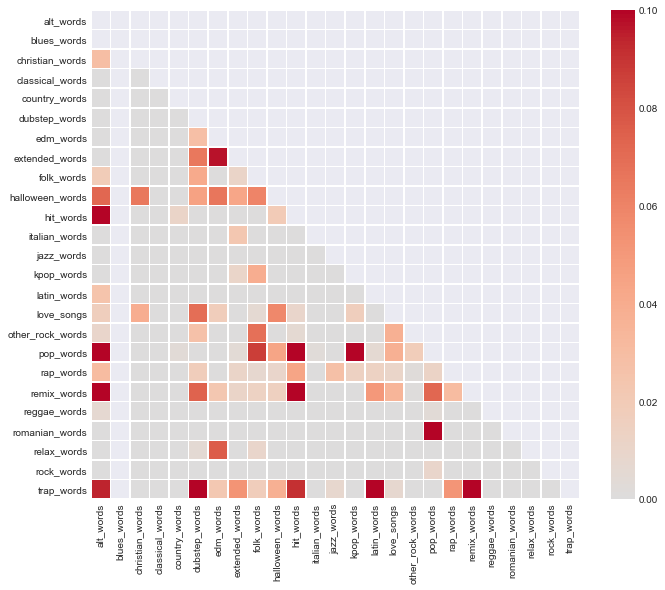

In [14]:
# Generate a mask for the upper triangle
mask = np.zeros_like(df_genres_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_genres_corr, mask=mask, cmap='coolwarm',vmin=0, vmax=.1, center=0,
            square=True, linewidths=.5, )

## Engagement Baseline

### Set up

In [15]:
df_formodel = df_main[(df_main.view_log>4)&(df_main.lv_ratio>0)&(df_main.comment_view_ratio>0)&(df_main.like_dislike_ratio<10)].reset_index()


In [16]:
X = df_formodel.loc[:, ['view_log']]

### Likes

In [17]:
y = df_formodel.view_log-df_formodel.like_log
lr_likes_views = LinearRegression()
lr_likes_views.fit(X,y)
lr_likes_views_m = lr_likes_views.coef_
lr_likes_views_b = lr_likes_views.intercept_
lv_resid = lr_likes_views.predict(X) - y
lr_likes_views_std = np.std(lv_resid)
r2_score(y, lr_likes_views.predict(X))

0.08616253624076575

In [18]:
df_formodel['like_baseline_delta'] = (lr_likes_views.predict(X) - y) / lr_likes_views_std

### Comments 

In [19]:
y = df_formodel.view_log - df_formodel.comment_log
lr_comments_views = LinearRegression()
lr_comments_views.fit(X,y)
lr_comments_views_m = lr_comments_views.coef_
lr_comments_views_b = lr_comments_views.intercept_
cv_resid = lr_likes_views.predict(X) - y
lr_comments_views_std = np.std(cv_resid)
r2_score(y, lr_comments_views.predict(X))

0.14905333750463512

In [20]:
df_formodel['comment_baseline_delta'] = (lr_comments_views.predict(X) - y) / lr_comments_views_std

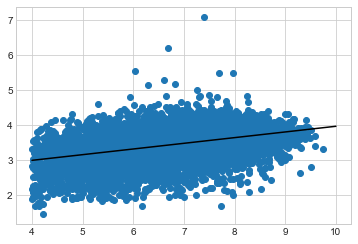

In [21]:
x = np.linspace(4, 10, 100)

fig, ax = plt.subplots()
ax.scatter(X, y)
ax.plot(x, x*lr_comments_views_m[0]+lr_comments_views_b ,'k')

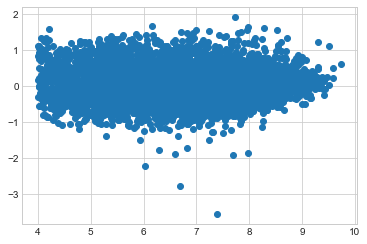

In [22]:
x = np.linspace(4, 10, 100)

fig, ax = plt.subplots()
ax.scatter(X, lr_comments_views.predict(X) - y)

### Dislikes

In [169]:
#Creating this for consistency
df_main['dislike_view_ratio'] = df_main.dislike_log / df_main.view_log

In [23]:
y = df_formodel.view_log-df_formodel.dislike_log
lr_dislikes_views = LinearRegression()
lr_dislikes_views.fit(X,y)
lr_dislikes_views_m = lr_dislikes_views.coef_
lr_dislikes_views_b = lr_dislikes_views.intercept_
dv_resid = lr_dislikes_views.predict(X) - y
lr_dislikes_views_std = np.std(dv_resid)
r2_score(y, lr_dislikes_views.predict(X))

0.007346286490757636

In [24]:
df_formodel['dislike_baseline_delta'] = (lr_dislikes_views.predict(X) -y) / lr_dislikes_views_std

### Like to Dislike Ratio

In [25]:
y = df_formodel.like_log - df_formodel.dislike_log
lr_likes_dislikes = LinearRegression()
lr_likes_dislikes.fit(X,y)
lr_likes_dislikes_m = lr_likes_dislikes.coef_
lr_likes_dislikes_b = lr_likes_dislikes.intercept_
lr_likes_dislikes_std = np.std(lr_likes_dislikes.predict(X) - y)
r2_score(y, lr_likes_dislikes.predict(X))

0.05270725362984685

In [26]:
df_formodel['ld_baseline_delta'] = (pd.Series(lr_likes_dislikes.predict(X)).map(lambda x: max(1, x)) - y) / lr_dislikes_views_std

In [27]:
preds_ld_adj =pd.Series(lr_likes_dislikes.predict(X)).map(lambda x: max(1, x))

r2_score(y, preds_ld_adj)

0.05270725362984685

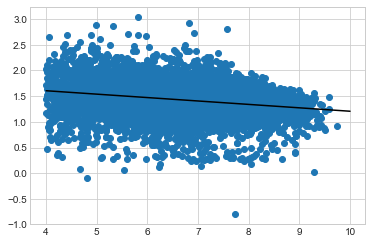

In [28]:
x = np.linspace(4, 10, 100)

fig, ax = plt.subplots()
ax.scatter(X, y)
ax.plot(x, x*lr_likes_dislikes_m+lr_likes_dislikes_b ,'k')

In [29]:
df_formodel[df_formodel.like_dislike_ratio<1].loc[:, ['title', 'view_log']]
#Convert preds to min 1 on likes to dislikes

,title,view_log
2458,Bibi H - How it is ( wap bap ... ) [Official V...,7.736840
3405,L'attaque des Titans Saison 3 Épisode 11 [VOST...,4.798644


In [30]:
slopes_list = pd.Series([lr_likes_views_m[0], lr_comments_views_m[0], lr_dislikes_views_m[0], lr_likes_dislikes_m[0]])
ints_list = pd.Series([lr_likes_views_b, lr_comments_views_b, lr_dislikes_views_b, lr_likes_dislikes_b])
stds_list = pd.Series([lr_likes_views_std, lr_comments_views_std, lr_dislikes_views_std, lr_likes_dislikes_std])

In [31]:
df_stats = pd.DataFrame([slopes_list, ints_list, stds_list], index=['Slopes', "Intercepts", "St_Dev"])

In [32]:
df_stats.columns=['likes_est', 'comments_est', 'dislikes_est', 'ld_ratio']

In [33]:
df_stats=df_stats.T

In [34]:
df_stats.loc['likes_est', 'Slopes']

0.09175390758873542

In [ ]:
df_formodel.to_csv('./data/engineered_data/data_genres_v2.csv', index=False)

df_stats.to_csv('./data/engineered_data/engagement_matrix_v2.csv')

In [185]:
deltas_list = ['like_baseline_delta', 'comment_baseline_delta', 'dislike_baseline_delta', 'ld_baseline_delta' ]